# PPO (Proximal Policy Optimization)

Based on https://colab.research.google.com/drive/1MsRlEWRAk712AQPmoM9X9E6bNeHULRDb?usp=sharing by Edan Meyer. See https://www.youtube.com/watch?v=HR8kQMTO8bk for a detailed description of the implementation

In [ ]:
!pip install gymnasium
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.distributions.categorical import Categorical

print(f"OpenAI Gym version: {gym.__version__}")
print(f'PyTorch version {torch.__version__}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00
OpenAI Gym version: 0.29.1
PyTorch version 2.1.0+cu118


### Helpers for video output

In [ ]:
# Video management imports
import cv2

# Helper functions to save videos and images


def save_video(img_array, path='./video/test.mp4'):
    height, width, layers = img_array[0].shape
    size = (width, height)
    out = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'mp4v'), 15, size)
    for i in range(len(img_array)):
        bgr_img = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR)
        out.write(bgr_img)
    out.release()
    print('Video saved.')


def save_images(img_array, path='./images'):
    for i, image in enumerate(img_array):
        bgr_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path + '/img_' + str(i) + '.jpg', bgr_img)

In [ ]:
DEVICE = 'cpu'

In [ ]:
# Policy and value model
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size, action_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU())

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size))

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value

    def select_action(self, obs):
        logits, val = self.forward(torch.tensor([obs], dtype=torch.float32, device=DEVICE))
        act_distribution = Categorical(logits=logits)
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).item()

        act, val = act.item(), val.item()
        return act, val, act_log_prob

## Training: Loss Function

The loss function for the actor is:

$$ \mathcal{L}(\theta_{t}) = \mathbb{E}_{t}[\min(r_t(\theta)A_{t}, clip(1-\epsilon, 1+\epsilon)A_t)] $$

where

- $r_t(\theta)$ represents the comparison between the probabilities of the old policies as compared to current policy: $$r_t(\theta)=\dfrac{\pi_\theta(a_t| s_t)}{\pi_{\theta_{old}}(a_t| s_t)}$$

- $A_{\pi}(S_t, A_t)$ is the advantage computed using the Generalized Advantage Estimation (GAE). In this case we estimate the advantage for each time step as: $$A_{t}(S_t, A_t)=GAE(t)=\sum_{k=0}^\infty (\lambda \gamma \delta(t+k)*(1-c)^k$$

Where:

- GAE(t) represents the Generalized Advantage Estimation at time step t.
- λ is the GAE parameter, which controls the trade-off between bias and variance in the advantage estimation. A value of 0 corresponds to using only one-step advantages, while a value of 1 corresponds to using full Monte Carlo (full-episode) advantages.
- γ is the discount factor, which determines the importance of future rewards compared to immediate rewards.
- δ(t) is the advantage at time step t, calculated as the difference between the estimated value function and the actual observed return at that time step.
- c is a coefficient used to truncate or clip the GAE, which can help reduce variance in the estimation.
By incorporating GAE into policy gradient algorithms like PPO, the algorithm can estimate more accurate advantages that balance the trade-off between immediate rewards and long-term rewards. This helps to improve the stability and performance of the algorithm by reducing bias and providing a better estimate of the action quality.




In [ ]:
class PPOTrainer():
    def __init__(self,
                 actor_critic,
                 ppo_clip_val=0.2,      # epsilon
                 target_kl_div=0.01,
                 max_policy_train_iters=80,
                 value_train_iters=80,
                 policy_lr=3e-4,        # Learning rate for policy function
                 value_lr=1e-2):        # Learning rate for value function
        self.model = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        # Get the parameters for the policy network
        policy_params = list(self.model.shared_layers.parameters()) + \
            list(self.model.policy_layers.parameters())
        # Define optimizer for policy model
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

        # Get the parameters for the value network
        value_params = list(self.model.shared_layers.parameters()) + \
            list(self.model.value_layers.parameters())
        # Define optimizer for value network
        self.value_optim = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        """Train the policy network max_policy_train_iters on current data"""
        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad()

            new_logits = self.model.policy(obs)
            new_logits = Categorical(logits=new_logits)
            new_log_probs = new_logits.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)

            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            policy_loss.backward()
            self.policy_optim.step()

            # This handles KL differently from the original PPO paper
            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div >= self.target_kl_div:
                break

    def train_value(self, obs, returns):
        """Train the value network max_policy_train_iters on current data"""
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.model.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()

In [ ]:
def discount_rewards(rewards, gamma=0.99):
    """
    Return discounted rewards based on the given rewards and gamma param.
    """
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])


def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/pdf/1506.02438.pdf
    """
    # values=[1,2,4] -> next_values=[2,4,0]
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

The rollout function generates a set of observations. Either information for an episode or for a maximun number of steps

In [ ]:
def rollout(model, env, max_steps=1000):
    """
    Performs a single rollout.
    Returns training data in the shape (n_steps, observation_shape)
    and the cumulative reward.
    """
    # Create data storage
    # obs, act, reward, values, act_log_probs
    train_data = [[], [], [], [], []]
    obs, _ = env.reset()

    ep_reward = 0
    for _ in range(max_steps):
        act, val, act_log_prob = model.select_action(obs)

        next_obs, reward, terminated, truncated, _ = env.step(act)
        done = terminated or truncated

        for i, item in enumerate((obs, act, reward, val, act_log_prob)):
            train_data[i].append(item)

        obs = next_obs
        ep_reward += reward
        if done:
            break

    train_data = [np.asarray(x) for x in train_data]

    # Do train data filtering
    train_data[3] = calculate_gaes(train_data[2], train_data[3])

    return train_data, ep_reward

## Training

In [ ]:
# Define training params
EPISODES = 200
PRINT_FREQ = 20
ENV_NAME = 'CartPole-v1'

In [ ]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.to(DEVICE)


Let's test our untrained policy to see how it fares

In [ ]:
train_data, reward = rollout(model, env)  # Test rollout function
print(f'Reward of test rollout: {reward}')

Reward of test rollout: 29.0


<ipython-input-5-5f9e88bd04d2>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  logits, val = self.forward(torch.tensor([obs], dtype=torch.float32, device=DEVICE))


In [ ]:
# Let's create our trainer
ppo = PPOTrainer(
    model,
    policy_lr=3e-4,
    value_lr=1e-3,
    target_kl_div=0.02,
    max_policy_train_iters=40,
    value_train_iters=40)

In [ ]:
# Training loop
episode_rewards = []
for episode in range(EPISODES):
    # Perform rollout
    train_data, reward = rollout(model, env)
    episode_rewards.append(reward)

    # Shuffle
    permute_idxs = np.random.permutation(len(train_data[0]))

    # Policy data
    obs = torch.tensor(train_data[0][permute_idxs],
                       dtype=torch.float32, device=DEVICE)
    acts = torch.tensor(train_data[1][permute_idxs],
                        dtype=torch.int32, device=DEVICE)
    gaes = torch.tensor(train_data[3][permute_idxs],
                        dtype=torch.float32, device=DEVICE)
    act_log_probs = torch.tensor(train_data[4][permute_idxs],
                                 dtype=torch.float32, device=DEVICE)

    # Value data
    rewards = discount_rewards(train_data[2])[permute_idxs]
    rewards = torch.tensor(rewards, dtype=torch.float32, device=DEVICE)

    # Train model
    ppo.train_policy(obs, acts, act_log_probs, gaes)
    ppo.train_value(obs, rewards)

    if (episode + 1) % PRINT_FREQ == 0:
        print(f'Episode {episode + 1}/{EPISODES} - Avg Reward {np.mean(episode_rewards[-PRINT_FREQ:]):.1f}')

Episode 20/200 - Avg Reward 44.0
Episode 40/200 - Avg Reward 213.2
Episode 60/200 - Avg Reward 333.4
Episode 80/200 - Avg Reward 433.6
Episode 100/200 - Avg Reward 429.4
Episode 120/200 - Avg Reward 486.9
Episode 140/200 - Avg Reward 305.6
Episode 160/200 - Avg Reward 296.8
Episode 180/200 - Avg Reward 213.3
Episode 200/200 - Avg Reward 129.1


## Testing the PPO Agent

In [ ]:
observation, _ = env.reset()
img_array = []
done = False
while not done:
    with torch.no_grad():
        action, _, _ = model.select_action(observation)
        observation, reward, done, truncated, info = env.step(action)
        done = done or truncated
        image = env.render()
        img_array.append(image)

save_video(img_array, './video/PPO_cart_pole.mp4')

Video saved.


In [ ]:
from IPython.display import Video
Video('./video/PPO_cart_pole.mp4', embed=True)

## Viewing Statistics

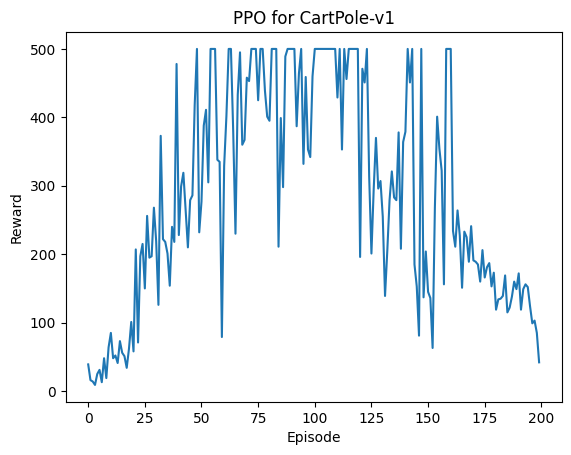

In [ ]:
x = np.arange(len(episode_rewards))
# Plot the values
plt.plot(x, episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'PPO for {ENV_NAME}')
plt.show()

## There are two clear observations that can be made from the graph. The first is that there are many more spikes, which could be due to PPO learning more effectively with each episode. The second is that the rewards obtained are significantly higher than with A2C. However, it’s important to point out that there is a significant drop in rewards. Still, it’s unusual for the average to fall from 500 to 120 over just 100 iterations. PPO does not appear to converge, which could suggest that there aren’t enough episodes. You can also see that the policy updates are more constrained, as there are no abrupt changes in the trend. Therefore, I believe more iterations are needed to reach a solid conclusion. That said, I still think PPO performs better, since the maximum reward achieved by A2C is 125 — which is very low compared to PPO.
